In [1]:
%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const

import lightkurve as lk

import sys
sys.path.append('/Users/james/Dropbox/research_projects/FFD/')
from FFD import FFD

from scipy.optimize import curve_fit

/Users/james/anaconda3/lib/python3.11/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/james/.lightkurve/cache. Please move all the files in the legacy directory /Users/james/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [3]:
lc0 = lk.search_lightcurve('GJ 1132')#, mission='TESS', author='SPOC')

In [4]:
lc = lk.search_lightcurve('GJ 1132', mission='TESS').download_all()

TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]


/Users/james/anaconda3/lib/python3.11/site-packages/lightkurve/lightcurve.py:1131: LightkurveWarning: The light curve appears to be zero-centered (median=1.48e+03 electron / s +/- 2.52e+15 electron / s); `normalize()` will divide the light curve by a value close to zero, which is probably not what you want.
  warnings.warn(
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]


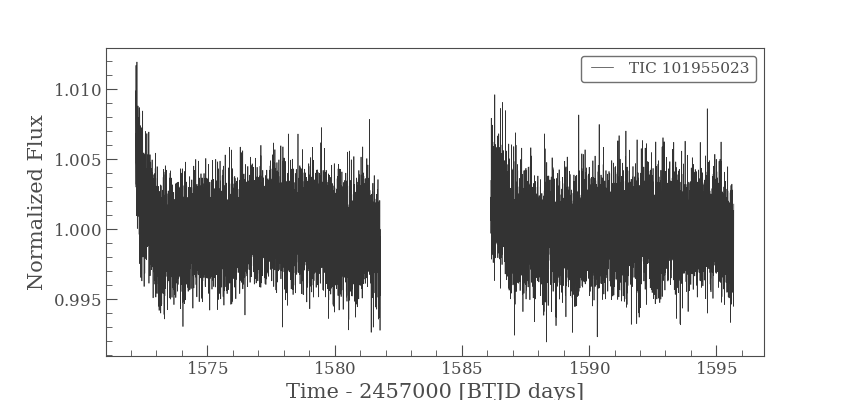

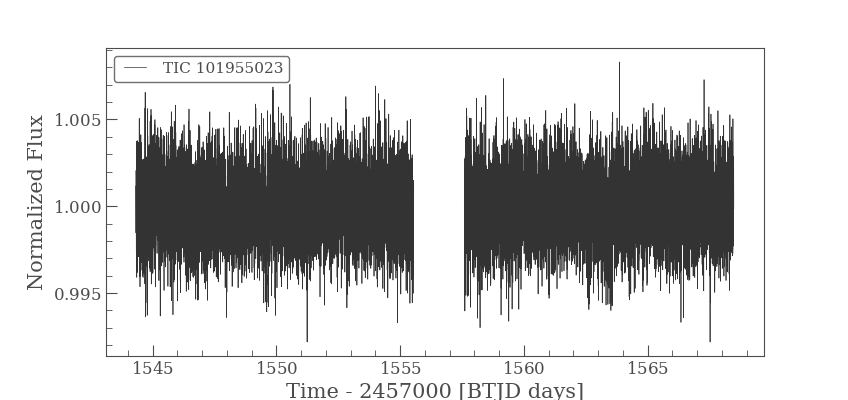

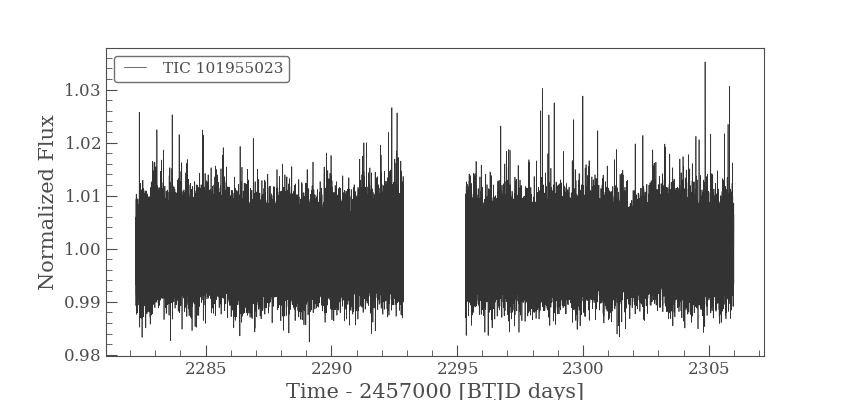

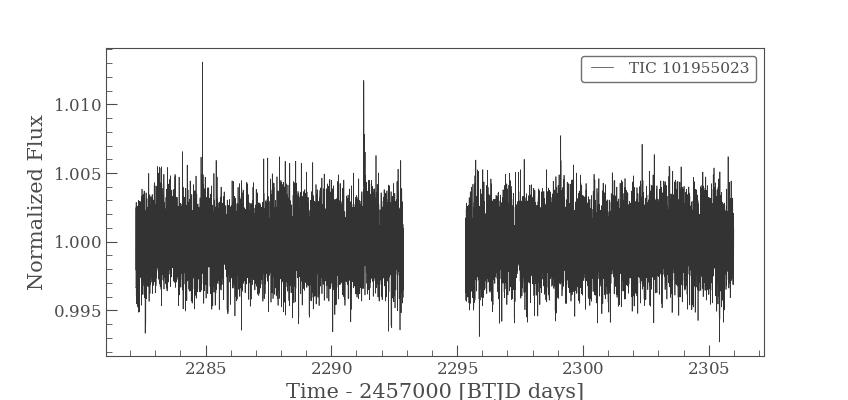

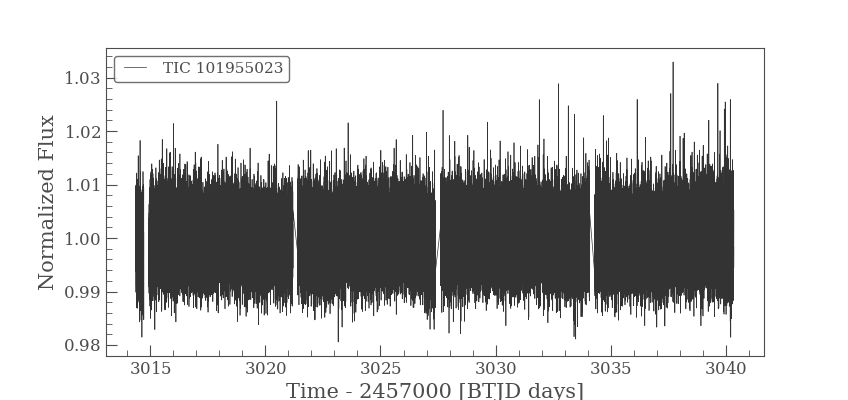

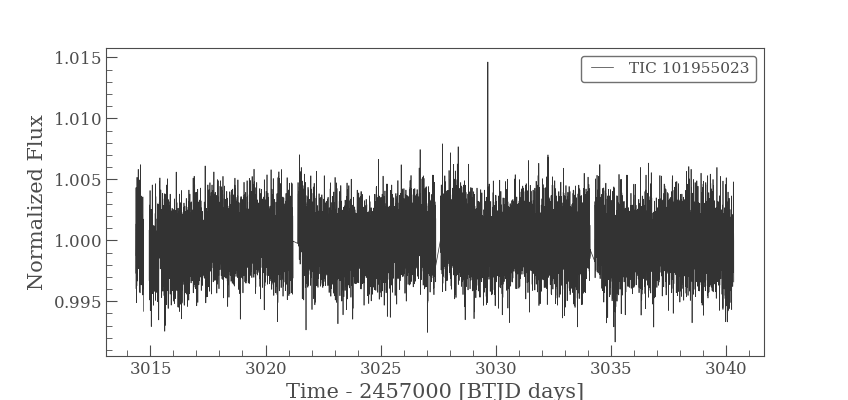

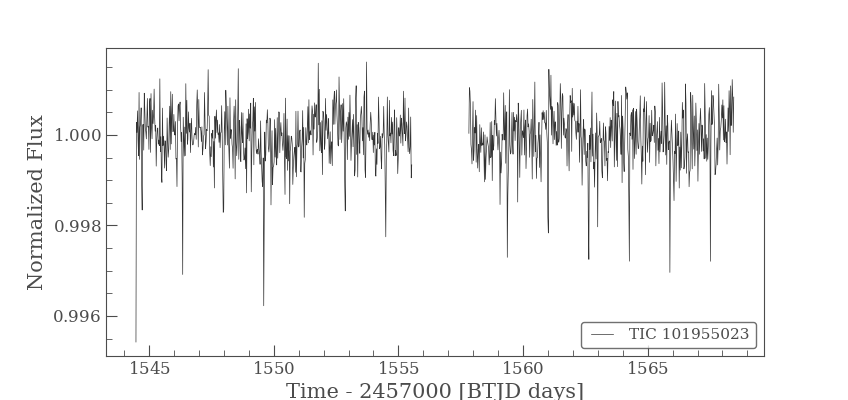

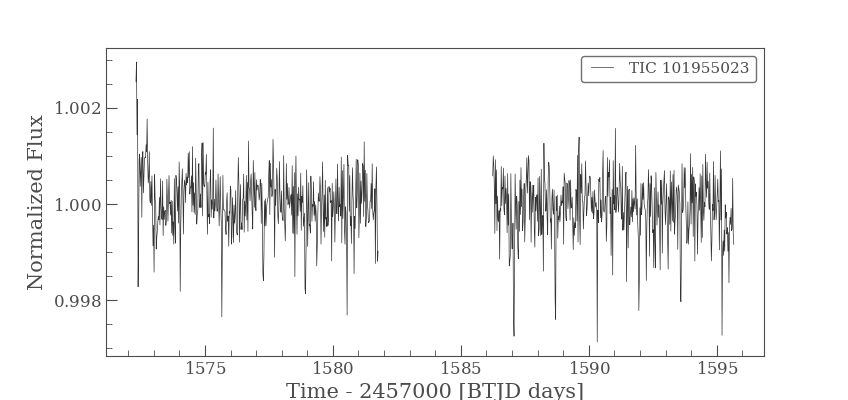

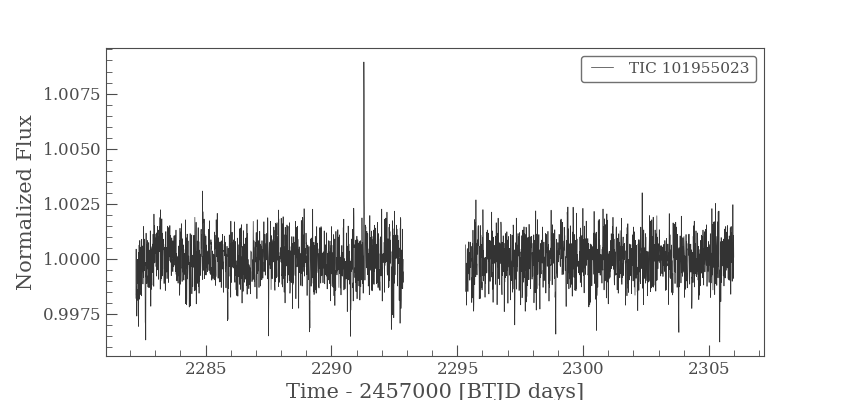

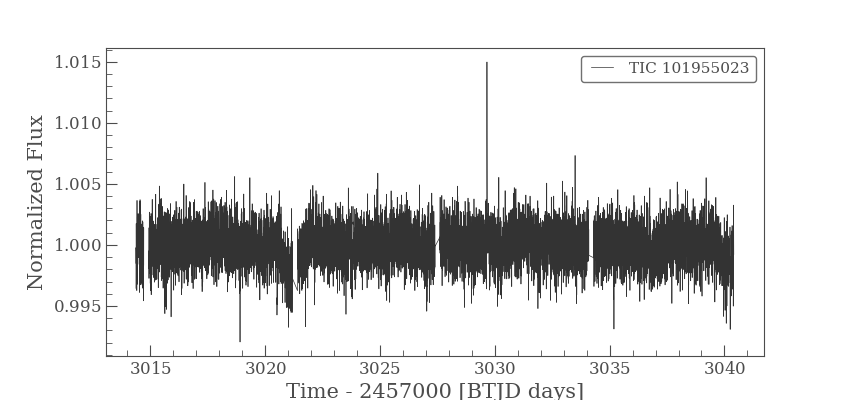

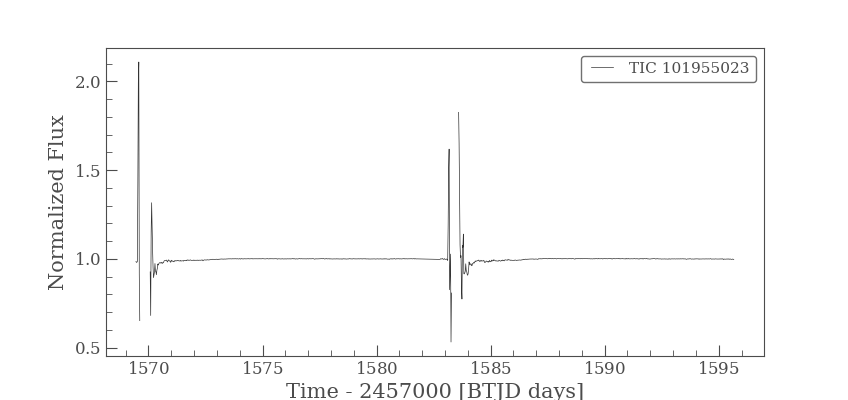

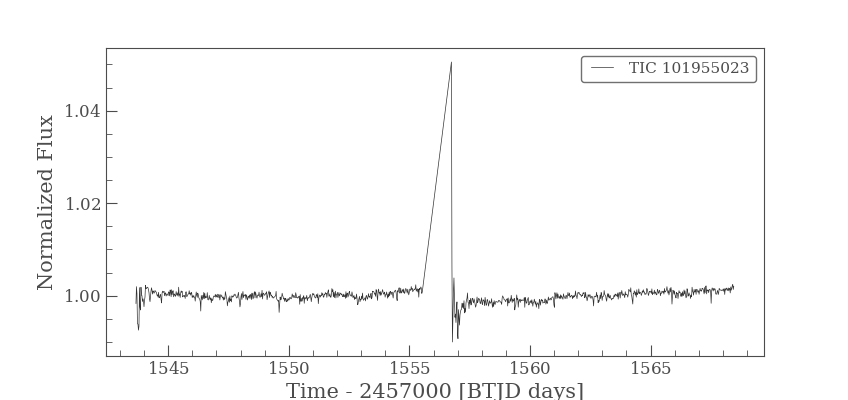

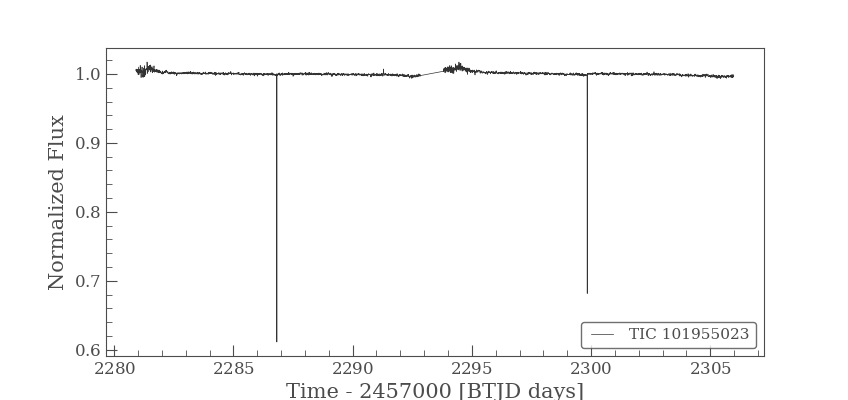

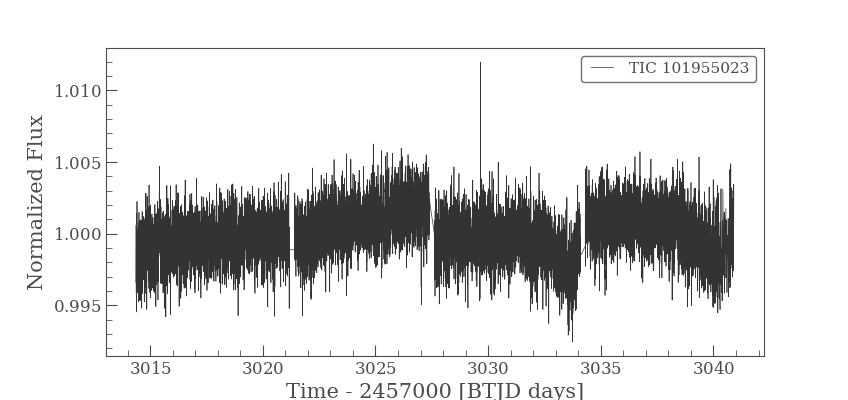

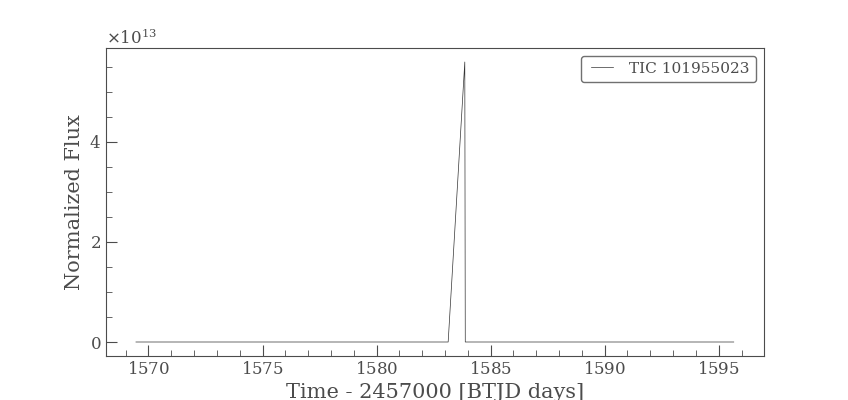

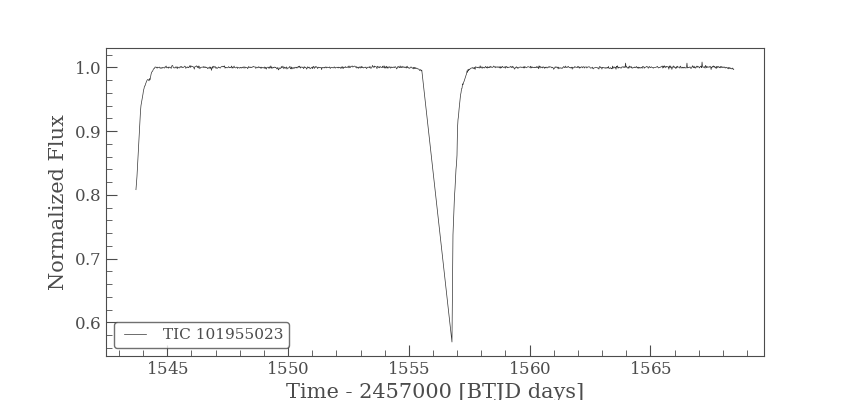

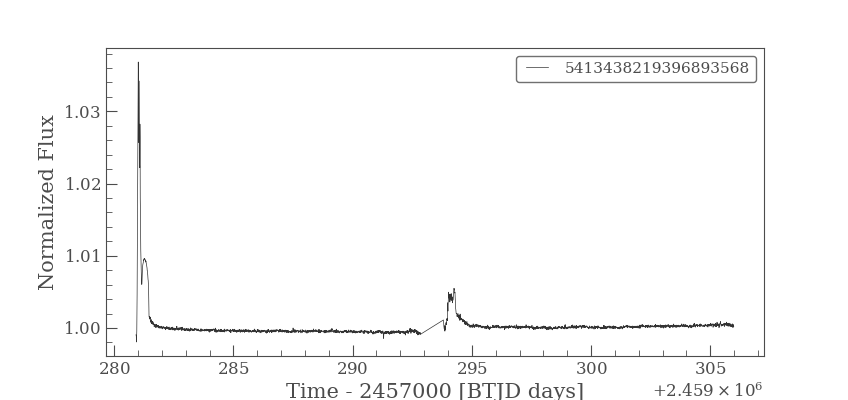

In [5]:
for k in range(len(lc)):
    lc[k].normalize().plot()

/Users/james/anaconda3/lib/python3.11/site-packages/lightkurve/lightcurve.py:1956: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1)


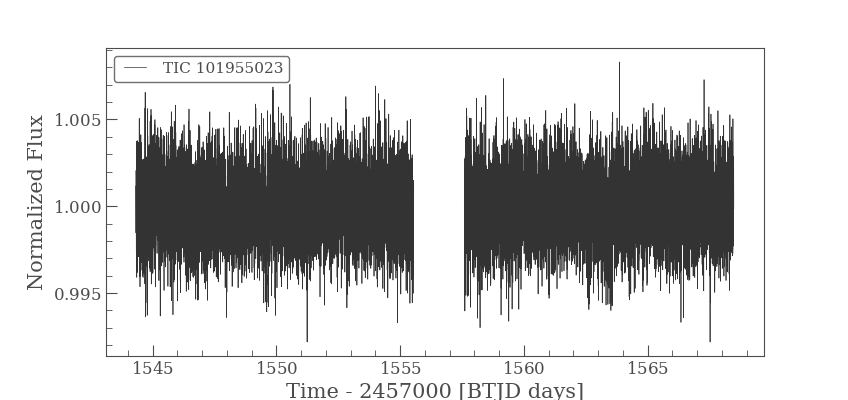

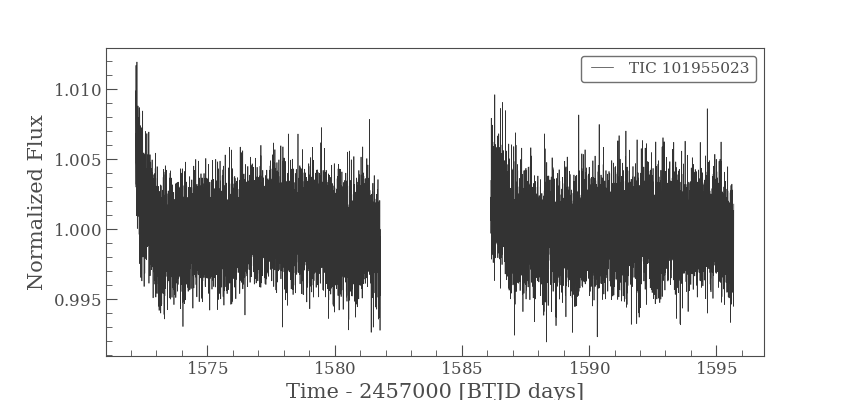

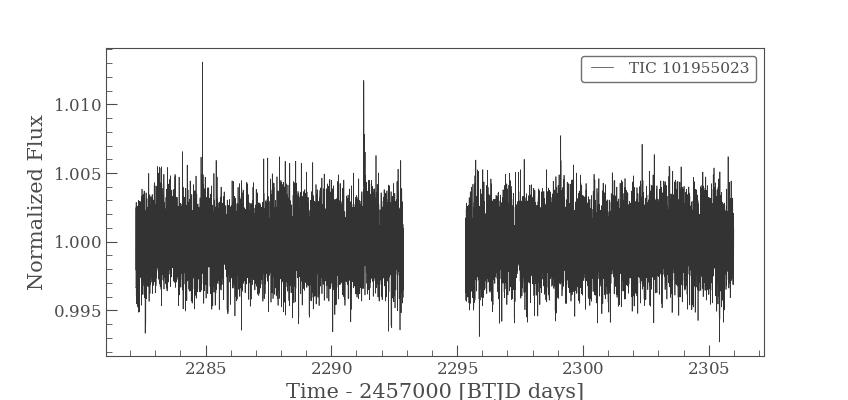

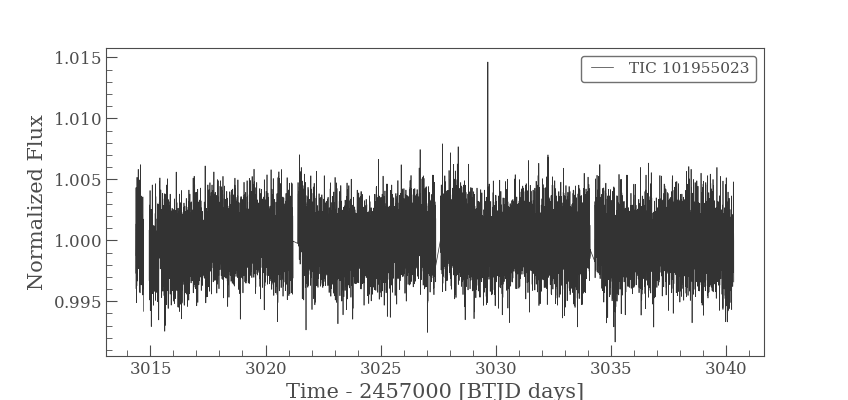

In [6]:
lc = lk.search_lightcurve('GJ 1132', mission='TESS', author='SPOC', exptime=120).download_all()

totexp = 0
for k in range(len(lc)):
    lc[k].normalize().plot()
    totexp += (len(lc[k]) * 2/60/24) # 2 min exposures

In [7]:
totexp

97.9625

In [8]:
sectors = [2,2,3]
t_start = np.array([2284.8817, 2291.2813, 3029.6533])
t_stop = np.array([2284.8905, 2291.3374, 3029.6852])

In [9]:
# https://iopscience.iop.org/article/10.3847/1538-3881/153/1/9/pdf
lumin = 4.38e-3 * const.L_sun.to('erg/s')
np.log10(lumin.value)
# GJ 1243 luminosity for TESS from Davenport+2020: 31.06

31.224446039608907

In [10]:
# compute Equiv Dur's, make FFD
ed = np.zeros(len(t_start), dtype=float)
for k in range(len(t_start)):
    flare = np.where((lc[sectors[k]]['time'].value >= t_start[k]) & 
                     (lc[sectors[k]]['time'].value <= t_stop[k])
                    )[0]
    ed[k] = np.trapz(lc[sectors[k]].normalize()['flux'].value[flare] - 1,  
                     lc[sectors[k]]['time'].value[flare]*60*60*24)

In [11]:
ffd_x, ffd_y, ffd_xerr, ffd_yerr = FFD(ed, TOTEXP=totexp, 
                                       Lum=np.log10(lumin.value), 
                                       fluxerr=np.nanmedian(lc[0].normalize()['flux_err']), 
                                       dur = t_stop - t_start, logY=True)

In [12]:
def ffd_fit(x, beta):
    alpha = -1
    return beta + (x * alpha)

In [13]:
popt, pcov = curve_fit(ffd_fit, ffd_x, ffd_y)
popt

array([30.32238695])

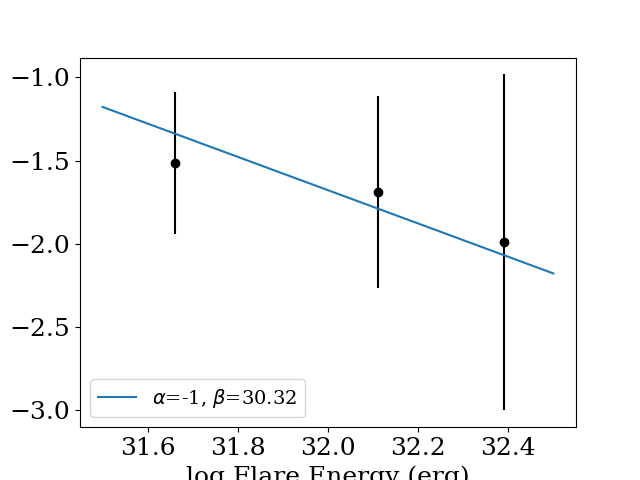

In [14]:
plt.figure()
plt.errorbar(ffd_x, ffd_y, yerr=ffd_yerr, linestyle='none', color='k')
plt.scatter(ffd_x, ffd_y, c='k')

plt.plot([31.5, 32.5], ffd_fit(np.array([31.5, 32.5]), popt[0]), label=r'$\alpha$=-1, $\beta$='+format(popt[0], '5.2f'))
# plt.plot(ed[np.argsort(ed)][::-1], np.arange(len(ed))+1)
plt.xlabel('log Flare Energy (erg)')
plt.ylabel('log Flare Rate (day$^{-1}$)')
plt.legend(fontsize=14, loc='lower left')

plt.savefig('GJ1132_FFD.png', dpi=150, bbox_inches='tight', pad_inches=0.25, facecolor='w')


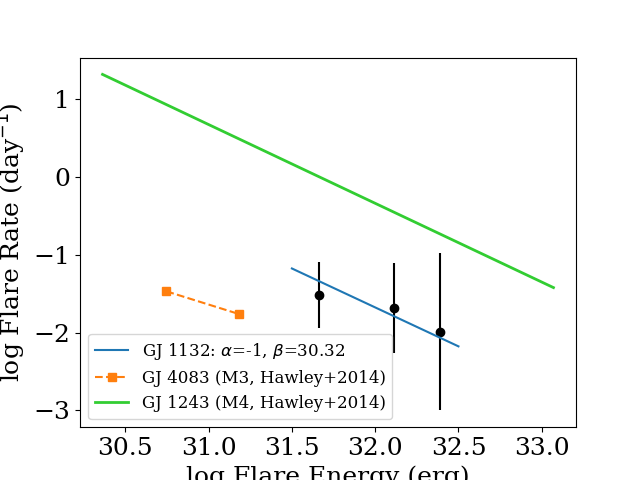

In [15]:
gj4083_x = np.array([30.746478873239436, 31.184663536776213])
gj4083_y = np.array([0.03380728065018358, 0.017198670673630925])

gj1243_y=[20.605975259769426, 0.03773912345819717]
gj1243_x=[30.363067292644757, 33.070422535211264]

plt.figure()
plt.errorbar(ffd_x, ffd_y, yerr=ffd_yerr, linestyle='none', color='k')
plt.scatter(ffd_x, ffd_y, c='k')

plt.plot([31.5, 32.5], ffd_fit(np.array([31.5, 32.5]), popt[0]), label=r'GJ 1132: $\alpha$=-1, $\beta$='+format(popt[0], '5.2f'))
# plt.plot(ed[np.argsort(ed)][::-1], np.arange(len(ed))+1)
plt.plot(gj4083_x, np.log10(gj4083_y), marker='s', linestyle='--', label='GJ 4083 (M3, Hawley+2014)')
plt.plot(gj1243_x, np.log10(gj1243_y), c='limegreen',lw=2, label='GJ 1243 (M4, Hawley+2014)')

plt.xlabel('log Flare Energy (erg)')
plt.ylabel('log Flare Rate (day$^{-1}$)')
plt.legend(fontsize=12)

plt.savefig('GJ1132_FFD_comp.png', dpi=150, bbox_inches='tight', pad_inches=0.25, facecolor='w')


In [16]:
def FlareEqn(X, a1, a2, a3, b1, b2, b3):
    '''
    The big FFD fitting equation, fititng both powerlaw slope and intercept as functions of mass and age

    THIS is the original version from Paper2 draft v1

    Parameters
    ----------
    X = (logE, logt, m)
        age in log Myr
        mass in Solar
        E in log erg

    Returns
    -------
    log Rate of flares

    '''
    logE, logt, m = X

    a = a1 * logt + a2 * m + a3
    b = b1 * logt + b2 * m + b3
    logR = logE * a + b

    return logR

params = np.array([ -0.06596571,  0.77855978, -1.0475149,  1.91734981, -24.57936264, 33.65312658])
stddev = [ 0.11161406, 0.39583476, 0.36173301, 3.83784203, 13.58271861, 12.34713725]


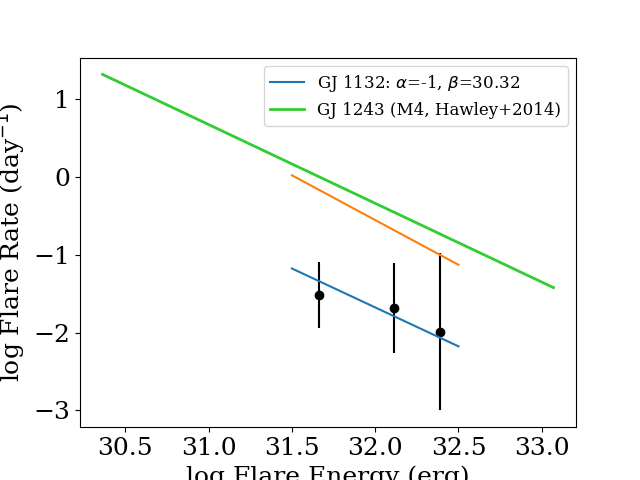

In [17]:
gj4083_x = np.array([30.746478873239436, 31.184663536776213])
gj4083_y = np.array([0.03380728065018358, 0.017198670673630925])

gj1243_y=[20.605975259769426, 0.03773912345819717]
gj1243_x=[30.363067292644757, 33.070422535211264]

plt.figure()
plt.errorbar(ffd_x, ffd_y, yerr=ffd_yerr, linestyle='none', color='k')
plt.scatter(ffd_x, ffd_y, c='k')

plt.plot([31.5, 32.5], ffd_fit(np.array([31.5, 32.5]), popt[0]), label=r'GJ 1132: $\alpha$=-1, $\beta$='+format(popt[0], '5.2f'))
# plt.plot(ed[np.argsort(ed)][::-1], np.arange(len(ed))+1)
# plt.plot(gj4083_x, np.log10(gj4083_y), marker='s', linestyle='--', label='GJ 4083 (M3, Hawley+2014)')
plt.plot(gj1243_x, np.log10(gj1243_y), c='limegreen',lw=2, label='GJ 1243 (M4, Hawley+2014)')

X = (np.array([31.5, 32.5]), np.log10([8000,8000]), np.array([0.2, 0.2]))
plt.plot([31.5, 32.5], FlareEqn(X, *params))

plt.xlabel('log Flare Energy (erg)')
plt.ylabel('log Flare Rate (day$^{-1}$)')
plt.legend(fontsize=12)

# plt.savefig('GJ1132_FFD_comp.png', dpi=150, bbox_inches='tight', pad_inches=0.25, facecolor='w')


Text(0, 0.5, 'Flare Rate (year$^{-1}$)')

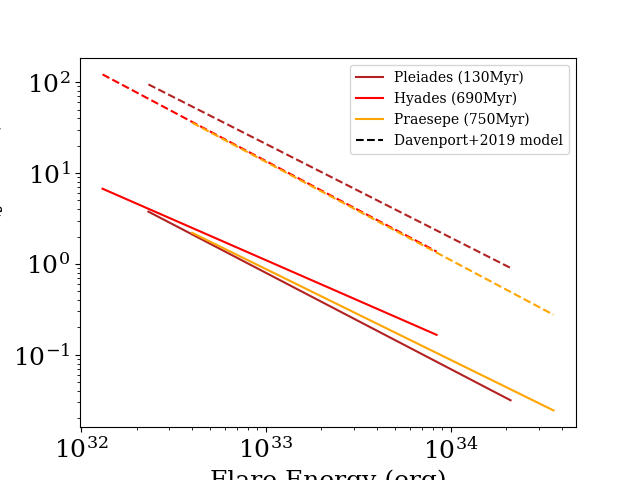

In [18]:
cluster = [ 'Hyades (690Myr)', 'Pleiades (130Myr)', 'Praesepe (750Myr)']
# T=3000-3250
Iages = np.array([ 690, 130, 750 ])

Ialpha = np.array([1.89, 2.06, 2.00])
Ibeta = np.array([2.3e29, 8.1e34, 8.8e32])

IEmin = np.array([1.31e32, 2.32e32, 0.4e33])
IEmax = np.array([0.84e34, 2.11e34, 0.36e35])

clrs = ['r', 'firebrick', 'orange']

def IFFD(E, alpha, beta):
    f = beta / (alpha - 1) * (E**(-alpha + 1))
    return f

# reproduce Ilin+2020, Fig 5b
plt.figure()
for k in [1,0,2]:
    plt.plot([IEmin[k], IEmax[k]], IFFD([IEmin[k], IEmax[k]], Ialpha[k], Ibeta[k]), c=clrs[k], label=cluster[k])
    
    X = (np.log10([IEmin[k], IEmax[k]]), 
         np.log10([Iages[k], Iages[k]]), 
         np.array([0.2, 0.2]))
    plt.plot([IEmin[k], IEmax[k]], 10**FlareEqn(X, *params)*365.25, c=clrs[k], linestyle='--')

plt.plot([], c='k', linestyle='--', label='Davenport+2019 model')
plt.legend(fontsize=10)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Flare Energy (erg)')
plt.ylabel('Flare Rate (year$^{-1}$)')

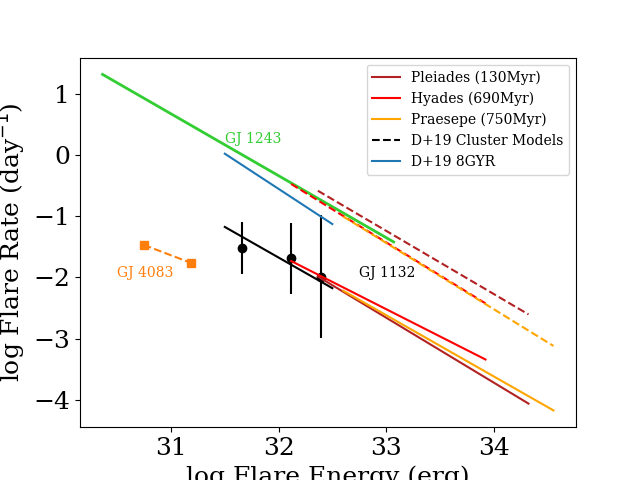

In [19]:

plt.figure()
plt.errorbar(ffd_x, ffd_y, yerr=ffd_yerr, linestyle='none', color='k')
plt.scatter(ffd_x, ffd_y, c='k')
plt.plot([31.5, 32.5], ffd_fit(np.array([31.5, 32.5]), popt[0]), c='k')#, label=r'GJ 1132: $\alpha$=-1, $\beta$='+format(popt[0], '5.2f'))
plt.text(32.75, -2, 'GJ 1132', color='k', fontsize=10)

plt.plot(gj4083_x, np.log10(gj4083_y), marker='s', linestyle='--', c='C1')
plt.text(30.5, -2,'GJ 4083', color='C1', fontsize=10)

plt.plot(gj1243_x, np.log10(gj1243_y), c='limegreen',lw=2)
plt.text(31.5,0.2 , 'GJ 1243', color='limegreen', fontsize=10)

# X = (np.array([31.5, 32.5]), np.log10([8000,8000]), np.array([0.2, 0.2]))
# plt.plot([31.5, 32.5], FlareEqn(X, *params), c='green', label='Davenport+2019 (8Gyr)')


for k in [1,0,2]:
    plt.plot(np.log10([IEmin[k], IEmax[k]]), 
             np.log10(IFFD([IEmin[k], IEmax[k]], Ialpha[k], Ibeta[k]))-np.log10(365.25), 
             c=clrs[k], label=cluster[k])
    
    X = (np.log10([IEmin[k], IEmax[k]]), 
         np.log10([Iages[k], Iages[k]]), 
         np.array([0.2, 0.2]))
    plt.plot(np.log10([IEmin[k], IEmax[k]]), FlareEqn(X, *params), c=clrs[k], linestyle='--')

plt.plot([], c='k', linestyle='--', label='D+19 Cluster Models')


X = (np.array([31.5, 32.5]), np.log10([8000,8000]), np.array([0.2, 0.2]))
plt.plot([31.5, 32.5], FlareEqn(X, *params), label='D+19 8GYR')


plt.xlabel('log Flare Energy (erg)')
plt.ylabel('log Flare Rate (day$^{-1}$)')
plt.legend(fontsize=10)

plt.savefig('GJ1132_FFD_comp2.png', dpi=150, bbox_inches='tight', pad_inches=0.25, facecolor='w')


In [ ]:
#  proxima:
# https://ui.adsabs.harvard.edu/abs/2018ApJ...860L..30H/abstract

Text(0, 0.5, 'log Flare Rate (day$^{-1}$)')

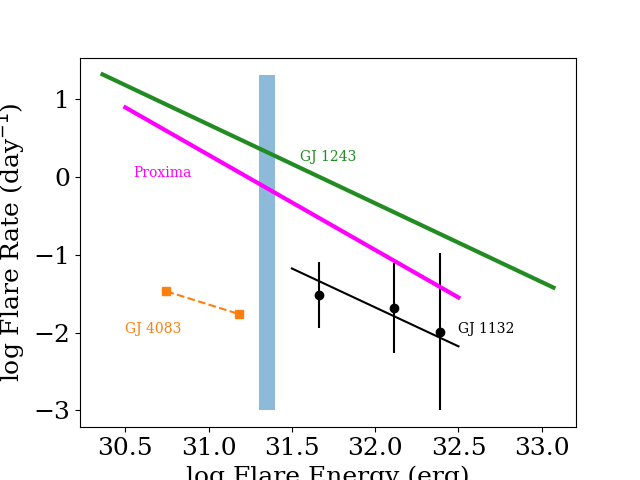

In [34]:

plt.figure()
plt.errorbar(ffd_x, ffd_y, yerr=ffd_yerr, linestyle='none', color='k')
plt.scatter(ffd_x, ffd_y, c='k')
plt.plot([31.5, 32.5], ffd_fit(np.array([31.5, 32.5]), popt[0]), c='k')
plt.text(32.5, -2, 'GJ 1132', color='k', fontsize=10)

plt.plot(gj4083_x, np.log10(gj4083_y), marker='s', linestyle='--', c='C1')
plt.text(30.5, -2,'GJ 4083', color='C1', fontsize=10)

plt.plot(gj1243_x, np.log10(gj1243_y), c='ForestGreen',lw=3)
plt.text(31.55,0.2 , 'GJ 1243', color='ForestGreen', fontsize=10)

plt.plot([30.5, 32.5], -1.22*np.array([30.5, 32.5])+38.1, c='Magenta', lw=3)
plt.text(30.55, 0, 'Proxima', color='Magenta', fontsize=10)

plt.fill_between([31.3,31.4], [-3,-3], [1.3,1.3],alpha=0.5)

plt.xlabel('log Flare Energy (erg)')
plt.ylabel('log Flare Rate (day$^{-1}$)')
# plt.legend(fontsize=10)

/var/folders/8t/yh7p62792_b_y17g3f6wk0wm0000gn/T/ipykernel_67731/3221405172.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m4083 = float(np.diff(np.log10(gj4083_y)) / np.diff(gj4083_x))


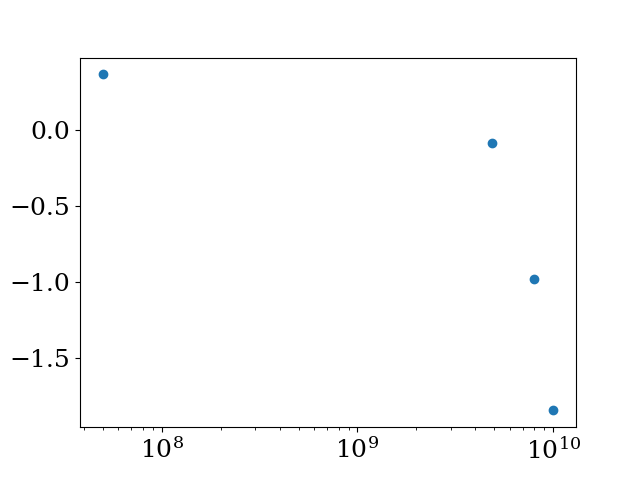

In [61]:
m4083 = float(np.diff(np.log10(gj4083_y)) / np.diff(gj4083_x))
b4083 = float((np.log10(gj4083_y)[0] - (m4083*gj4083_x[0])))

m1243 = float((np.log10(gj1243_y[1]) - np.log10(gj1243_y[0]))/(gj1243_x[1] - gj1243_x[0]))
b1243 = float(np.log10(gj1243_y[1]) - (m1243*gj1243_x[1]))

# gj1243, proxima, gj1132, gj4083
ages = np.array([50e6, 4.853e9, 8e9, 10e9])
f313 = np.array([ m1243*31.3 + b1243,  
                -1.22*31.3+38.1, 
                ffd_fit(np.array([31.3]), popt[0])[0], 
                m4083*31.3 + b4083])

plt.figure()
plt.scatter(ages, f313)
plt.xscale('log')

In [57]:
ffd_fit(np.array([31.3]), popt[0])[0]

-0.9776130510638552

In [53]:
m1243*31.3 + b1243

0.3667316380279715

In [41]:
y=mx+b

array([19.12435397])